In [1]:
from datasets import load_dataset
import re
import string
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

In [2]:
dataset = load_dataset("imdb")
os.chdir('..')

Reusing dataset imdb (/Users/dsrinivas/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
log_dir = 'logs/'
results_dir = 'results/'

In [4]:
# https://stackoverflow.com/questions/3398852/using-python-remove-html-tags-formatting-from-a-string
# https://stackoverflow.com/questions/1546226/is-there-a-simple-way-to-remove-multiple-spaces-in-a-string
html_tag_re = re.compile(r'<.*?>')
multi_space_re = re.compile(r'\s\s+')

def pre_process(text) : 
    
    text = text.lower()
    text = html_tag_re.sub(' ', text)
    text = multi_space_re.sub(' ', text)
    text = ''.join([char for char in text if char not in string.punctuation])
    return text

def get_count_of_tokens(text) : 
    
    return len(text.split(" "))

Average token length is : 231.49608
Standard deviation of token is : 171.9681311889898


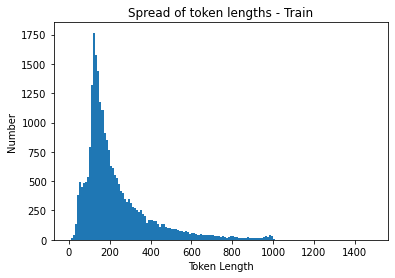

In [5]:
train_token_lens = []
for text in dataset['train']['text'] : 
    train_token_lens.append(get_count_of_tokens(pre_process(text)))

token_length_avg = np.mean(train_token_lens)
token_length_std = np.std(train_token_lens)
    
print("Average token length is : {}".format(token_length_avg))
print("Standard deviation of token is : {}".format(token_length_std))

plt.hist(train_token_lens, bins=range(0,1500,10))
plt.xlabel("Token Length")
plt.ylabel("Number")
plt.title("Spread of token lengths - Train")
plt.show()

Average token length is : 226.25972
Standard deviation of token is : 167.1058123032278


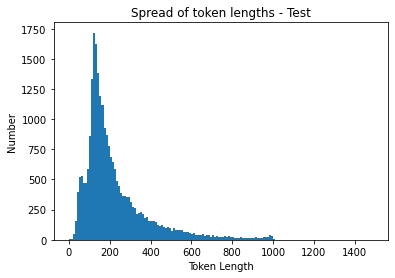

In [6]:
test_token_lens = []
for text in dataset['test']['text'] : 
    test_token_lens.append(get_count_of_tokens(pre_process(text)))

token_length_avg = np.mean(test_token_lens)
token_length_std = np.std(test_token_lens)
    
print("Average token length is : {}".format(token_length_avg))
print("Standard deviation of token is : {}".format(token_length_std))

plt.hist(test_token_lens, bins=range(0,1500,10))
plt.xlabel("Token Length")
plt.ylabel("Number")
plt.title("Spread of token lengths - Test")
plt.show()

In [7]:
from tensorflow.keras.layers import TextVectorization

In [8]:
sequence_length = int(token_length_avg*2)
vocabulary_size = 10000

vectorizer = TextVectorization(max_tokens=vocabulary_size, output_sequence_length=sequence_length)
vectorizer.adapt(dataset['train']['text'])

vocabulary = vectorizer.get_vocabulary()
vocabulary_size = len(vocabulary)

print("The output sequence length is {}".format(sequence_length))
print("There are {} words in this vocabulary".format(vocabulary_size))

The output sequence length is 452
There are 10000 words in this vocabulary


In [9]:
def bifurcate_dataset(token_lens, X, Y) : 
    
    bifurcated_dataset = {'short' : {'X' : [] , 'Y' : []}, 
                          'medium' : {'X' : [], 'Y' : []},
                          'long' : {'X' : [], 'Y' : []}}
    
    assert len(token_lens)==X.shape[0]
    assert len(token_lens)==Y.shape[0]
    
    sorted_token_len_i = np.argsort(token_lens)

    first_bifurcation = int(len(token_lens)/3)
    second_bifurcation = int(2*len(token_lens)/3)

    short_review_indices  = tuple(sorted_token_len_i[:first_bifurcation])
    medium_review_indices = tuple(sorted_token_len_i[first_bifurcation:second_bifurcation])
    long_review_indices = tuple(sorted_token_len_i[second_bifurcation:])
    
    print("# short indices : {}, # medium indices : {} , # long indices : {}".format(len(short_review_indices), 
                                                                                    len(medium_review_indices),
                                                                                    len(long_review_indices)))
    
    bifurcated_dataset['short']['X'] = X[[short_review_indices]]
    bifurcated_dataset['medium']['X'] = X[[medium_review_indices]]
    bifurcated_dataset['long']['X'] = X[[long_review_indices]]
    
    bifurcated_dataset['short']['Y'] = Y[[short_review_indices]]
    bifurcated_dataset['medium']['Y'] = Y[[medium_review_indices]]
    bifurcated_dataset['long']['Y'] = Y[[long_review_indices]]

    return bifurcated_dataset
    

In [10]:
word2id = dict(zip(vocabulary, range(vocabulary_size)))

In [11]:
x_train = vectorizer(np.array([[s] for s in dataset['train']['text']])).numpy()
x_test = vectorizer(np.array([[s] for s in dataset['test']['text']])).numpy()

y_train = np.array(dataset['train']['label'])
y_test = np.array(dataset['test']['label'])

In [12]:
train_dataset = bifurcate_dataset(train_token_lens, x_train, y_train)
test_dataset = bifurcate_dataset(test_token_lens, x_test, y_test)

train_dataset['all'] = {'X':x_train, 'Y':y_train}
test_dataset['all'] = {'X':x_test, 'Y':y_test}

# short indices : 8333, # medium indices : 8333 , # long indices : 8334
# short indices : 8333, # medium indices : 8333 , # long indices : 8334


<ipython-input-9-2a3a7eb36ef2>:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bifurcated_dataset['short']['X'] = X[[short_review_indices]]
<ipython-input-9-2a3a7eb36ef2>:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bifurcated_dataset['medium']['X'] = X[[medium_review_indices]]
<ipython-input-9-2a3a7eb36ef2>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will 

In [13]:
embedding_dimension = 100
path_to_glove_file = "data/glove.6B.{}d.txt".format(embedding_dimension)
assert os.path.exists(path_to_glove_file)

word2embedding = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split (maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        word2embedding[word] = coefs

print("Embedding dimension: {}.".format(embedding_dimension))

Embedding dimension: 100.


In [14]:
embedding_weights = np.zeros((vocabulary_size, embedding_dimension))
num_encoded_words = 0

for word, id in word2id.items() : 
    if word in word2embedding: 
        embedding_weights[id] = word2embedding[word]
        num_encoded_words += 1
        
print("{}/{} words have been encoded.".format(num_encoded_words, vocabulary_size))

9691/10000 words have been encoded.


In [15]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import Constant

embedding_layer = Embedding(vocabulary_size, embedding_dimension,
                            embeddings_initializer= Constant(embedding_weights), 
                            trainable=False)

In [16]:
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, GRU, RNN
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Model
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives

In [17]:
def get_model(recursive_layer, bidirectional=False) : 
        
    if recursive_layer == "lstm" : 
        recursive_layer = LSTM
    elif recursive_layer == "gru" : 
        recursive_layer = GRU
    else : 
        recursive_layer = RNN
    
    input_layer = Input(shape=(sequence_length, ))
    embedding = embedding_layer(input_layer)
    
    if bidirectional : 
        lstm = recursive_layer(64, return_sequences=True)(embedding)
        lstm = recursive_layer(64)(lstm)
    else : 
        lstm = Bidirectional(recursive_layer(64, return_sequences=True))(embedding)
        lstm = Bidirectional(recursive_layer(64))(lstm)
        
    dense = Dense(64, activation='relu')(lstm)
    dense = Dense(32, activation='relu')(dense)
    output = Dense(1, activation='sigmoid')(dense)
    
    model = Model(inputs=[input_layer], outputs=[output])
    model.compile(loss=BinaryCrossentropy(), 
                  optimizer=Adam(),
                  metrics=[TruePositives(), 
                           TrueNegatives(), 
                           FalsePositives(), 
                           FalseNegatives()]
                 )
    return model


def plot_loss(plot_name, loss) :
        
    plot_save_path = os.path.join(results_dir, plot_name+'.jpg')
    
    
    plt.plot(loss, labels=['Training Loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(plot_name)
    plt.xticks(np.arange(0, len(loss)+6, 5))
    plt.grid()
    plt.savefig(plot_save_path)
    


In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=3)

recursion_layers = ['lstm', 'gru', 'rnn']
bidirectionality = [True, False] 

Epoch 1/10
66/66 [==============================] - 62s 799ms/step - loss: 0.6342 - true_positives_1: 2585.0000 - true_negatives_1: 2662.0000 - false_positives_1: 1438.0000 - false_negatives_1: 1648.0000
Epoch 2/10
66/66 [==============================] - 47s 703ms/step - loss: 0.5009 - true_positives_1: 3234.0000 - true_negatives_1: 3098.0000 - false_positives_1: 1002.0000 - false_negatives_1: 999.0000
Epoch 3/10
66/66 [==============================] - 47s 712ms/step - loss: 0.4475 - true_positives_1: 3357.0000 - true_negatives_1: 3295.0000 - false_positives_1: 805.0000 - false_negatives_1: 876.0000
Epoch 4/10
66/66 [==============================] - 48s 724ms/step - loss: 0.4225 - true_positives_1: 3439.0000 - true_negatives_1: 3284.0000 - false_positives_1: 816.0000 - false_negatives_1: 794.0000
Epoch 5/10
66/66 [==============================] - 47s 711ms/step - loss: 0.3872 - true_positives_1: 3509.0000 - true_negatives_1: 3391.0000 - false_positives_1: 709.0000 - false_negatives

KeyboardInterrupt: 

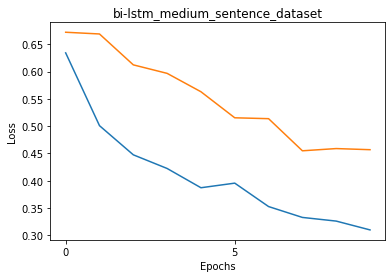

In [21]:
for train_bifurcation in train_dataset.keys() : 
    for recursion_layer in recursion_layers:
        for bidirectional in bidirectionality: 
            
            if bidirectional : 
                model_name = 'bi-{}_{}_sentence_dataset'.format(recursion_layer, train_bifurcation)
            else : 
                model_name = '{}_{}_sentence_dataset'.format(recursion_layer, train_bifurcation)
              
            log_path = os.path.join(log_dir, model_name+'.txt')
            train_log_path = os.path.join(log_dir, model_name+'.csv')
            
            log_file = open(log_path, 'w')
            log = "\nTraining for {}\n".format(model_name)

            model = get_model(recursion_layer)

            start_time = time.time()

            history = model.fit(train_dataset[train_bifurcation]['X'], 
                            train_dataset[train_bifurcation]['Y'], 
                            batch_size=128, 
                            callbacks=[early_stopping], 
                            epochs=10)

            total_time = time.time() - start_time

            log_file.write('Total time taken to train : {} seconds'.format(round(total_time, 2)))

            train_history_df = pd.DataFrame(history.history)
            train_history_df.to_csv(train_log_path, index=False)
                                    

            # plot_loss(model_name, history.history['loss'])

            for test_bifurcation in test_dataset.keys() : 

                log += "Validating on {} sentences ".format(test_bifurcation)
                log += "loss\tTP\tTN\tFP\tFN\n"

                results = model.evaluate(test_dataset[test_bifurcation]['X'], 
                                         test_dataset[test_bifurcation]['Y'],
                                         batch_size=128)


                for result in results:
                    log += "{}\t".format(round(result, 2))

                log += "\n"


                log_file.write(log)
                log_file.flush()
                log_file.close()

                log = "\n"

### Questions to ask : 

1. Bidirectional OK? (No, any number of layers ok as long as consistent)
2. Code copy OK? (Coding tutorial, citation required, comments to ensure that you understand the code )
3. Word2Vec source? (Any embedding OK, as long as at least 2)
4. General trends? (Carefully read requirements from question)
5. Splits are bad, sticking with them

### Things to report : 

1. 